In [111]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [112]:
data = pd.read_csv(r"C:\Users\MaxDH\Downloads\ETTh1.csv")

In [113]:
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [114]:
data['date']

0        2016-07-01 00:00:00
1        2016-07-01 01:00:00
2        2016-07-01 02:00:00
3        2016-07-01 03:00:00
4        2016-07-01 04:00:00
                ...         
17415    2018-06-26 15:00:00
17416    2018-06-26 16:00:00
17417    2018-06-26 17:00:00
17418    2018-06-26 18:00:00
17419    2018-06-26 19:00:00
Name: date, Length: 17420, dtype: object

In [115]:
data.isna().sum()

date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64

In [116]:
values = data.values

In [117]:
groups = [1, 2, 3, 4, 5, 6, 7]
i = 1

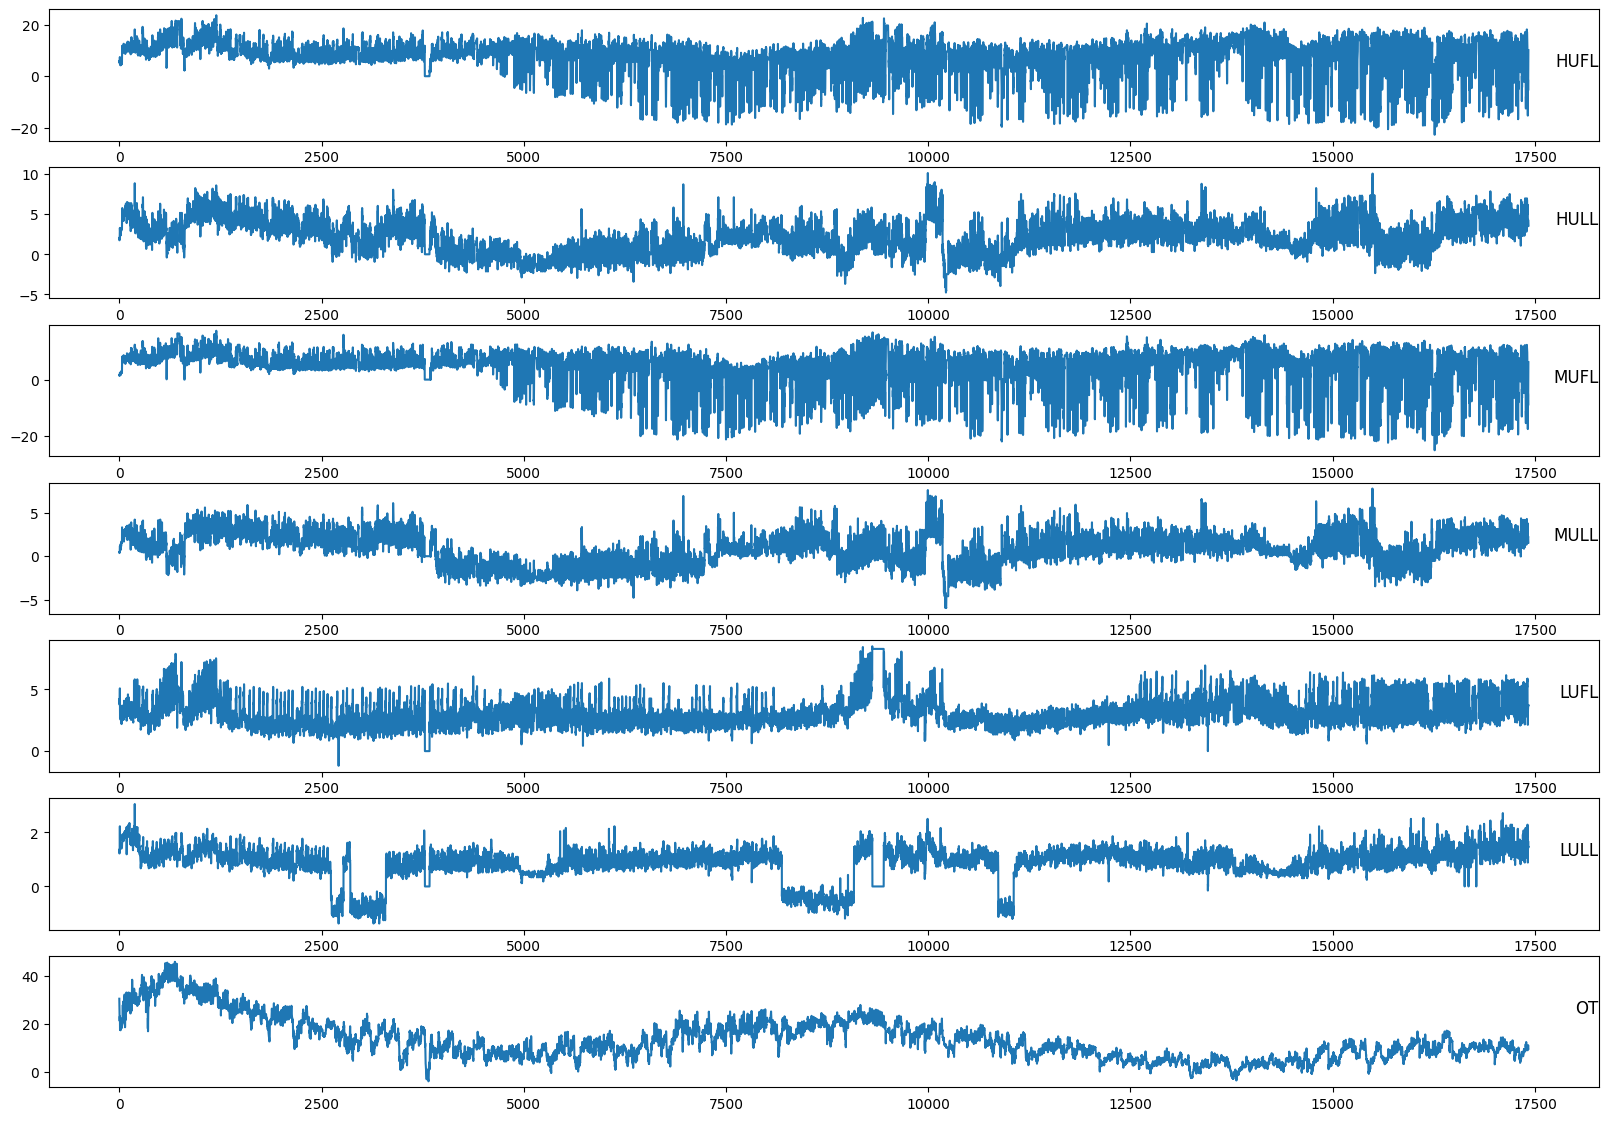

In [118]:
plt.figure(figsize=(20, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()


In [119]:
data.dtypes

date     object
HUFL    float64
HULL    float64
MUFL    float64
MULL    float64
LUFL    float64
LULL    float64
OT      float64
dtype: object

In [120]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [121]:
df = series_to_supervised(data)

In [122]:
df.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
5,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000


In [123]:
df.drop(df.columns[[0, 8]], axis=1, inplace=True)


In [124]:
df.head()

,var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.693,2.076,1.492,0.426,4.142,1.371,27.787001,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.157,1.741,1.279,0.355,3.777,1.218,27.787001,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
5,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,5.626,2.143,1.528,0.533,4.051,1.371,21.174000


In [125]:

data.drop(columns=['date'], inplace=True)
data.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [126]:
values = data.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.615599,0.454943,0.628980,0.467510,0.556576,0.613765,0.691018,0.612708,0.459449,0.626458,0.464878,0.550279,0.620783,0.636233
2,0.612708,0.459449,0.626458,0.464878,0.550279,0.620783,0.636233,0.601143,0.436920,0.621438,0.459689,0.512596,0.586145,0.636233
3,0.601143,0.436920,0.621438,0.459689,0.512596,0.586145,0.636233,0.599698,0.450437,0.621438,0.462320,0.515693,0.599955,0.581468
4,0.599698,0.450437,0.621438,0.462320,0.515693,0.599955,0.581468,0.605480,0.450437,0.626458,0.467510,0.521991,0.599955,0.519656
5,0.605480,0.450437,0.626458,0.467510,0.521991,0.599955,0.519656,0.611262,0.463954,0.627307,0.472699,0.540884,0.620783,0.504203


In [127]:
reframed.drop(reframed.columns[[7, 8, 9, 10, 11, 12]], inplace=True, axis=1)


In [128]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.615599   0.454943   0.628980   0.467510   0.556576   0.613765   
2   0.612708   0.459449   0.626458   0.464878   0.550279   0.620783   
3   0.601143   0.436920   0.621438   0.459689   0.512596   0.586145   
4   0.599698   0.450437   0.621438   0.462320   0.515693   0.599955   
5   0.605480   0.450437   0.626458   0.467510   0.521991   0.599955   

   var7(t-1)   var7(t)  
1   0.691018  0.636233  
2   0.636233  0.636233  
3   0.636233  0.581468  
4   0.581468  0.519656  
5   0.519656  0.504203  


In [129]:
reframed.shape

(17419, 8)

In [130]:
X = reframed.drop(columns=['var7(t)'])  # all columns except the target
y = reframed['var7(t)']                 # the target variable

In [131]:
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [132]:
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [133]:
X_test.shape

(3484, 1, 7)

In [134]:
y_test.shape

(3484,)

In [135]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm = nn.LSTM(input_size=7, hidden_size=64, num_layers=1, batch_first=True, dropout=0.2)  # Added dropout to LSTM
        self.dropout = nn.Dropout(0.2)  # Dropout layer after LSTM
        self.fc = nn.Linear(64, 1)  # Predict one value: var7(t)

    def forward(self, x):
        out, _ = self.lstm(x)  # x shape: (batch, seq_len, input_size)
        out = self.dropout(out[:, -1, :])  # Apply dropout before fully connected layer
        out = self.fc(out)  # Predict output
        return out


In [136]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # Initialize bias to zero
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                torch.nn.init.zeros_(param)



In [137]:
y_train_tensor = torch.tensor(y_train.to_numpy().reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy().reshape(-1, 1), dtype=torch.float32)


In [138]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [139]:
seq = Sequence()
criterion = nn.MSELoss()
optimizer = optim.Adam(seq.parameters())  # Add weight decay

c:\Users\MaxDH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [140]:
loss_list = []
test_loss_list = []

In [141]:
epoch_num = 100

In [142]:
for epoch in range(epoch_num):
    print('epoch : ', epoch)

    def closure():
        optimizer.zero_grad()
        out = seq(X_train_tensor)
        loss = criterion(out, y_train_tensor)
        loss_list.append(loss.item())  # Use item() to get the scalar value of loss
        loss.backward()
        return loss

    optimizer.step(closure)

    # Predict on the test data
    pred = seq(X_test_tensor)
    loss = criterion(pred, y_test_tensor)
    test_loss_list.append(loss.item())  # Use item() to get the scalar value of loss


epoch :  0
epoch :  1
epoch :  2
epoch :  3
epoch :  4
epoch :  5
epoch :  6
epoch :  7
epoch :  8
epoch :  9
epoch :  10
epoch :  11
epoch :  12
epoch :  13
epoch :  14
epoch :  15
epoch :  16
epoch :  17
epoch :  18
epoch :  19
epoch :  20
epoch :  21
epoch :  22
epoch :  23
epoch :  24
epoch :  25
epoch :  26
epoch :  27
epoch :  28
epoch :  29
epoch :  30
epoch :  31
epoch :  32
epoch :  33
epoch :  34
epoch :  35
epoch :  36
epoch :  37
epoch :  38
epoch :  39
epoch :  40
epoch :  41
epoch :  42
epoch :  43
epoch :  44
epoch :  45
epoch :  46
epoch :  47
epoch :  48
epoch :  49
epoch :  50
epoch :  51
epoch :  52
epoch :  53
epoch :  54
epoch :  55
epoch :  56
epoch :  57
epoch :  58
epoch :  59
epoch :  60
epoch :  61
epoch :  62
epoch :  63
epoch :  64
epoch :  65
epoch :  66
epoch :  67
epoch :  68
epoch :  69
epoch :  70
epoch :  71
epoch :  72
epoch :  73
epoch :  74
epoch :  75
epoch :  76
epoch :  77
epoch :  78
epoch :  79
epoch :  80
epoch :  81
epoch :  82
epoch :  83
ep

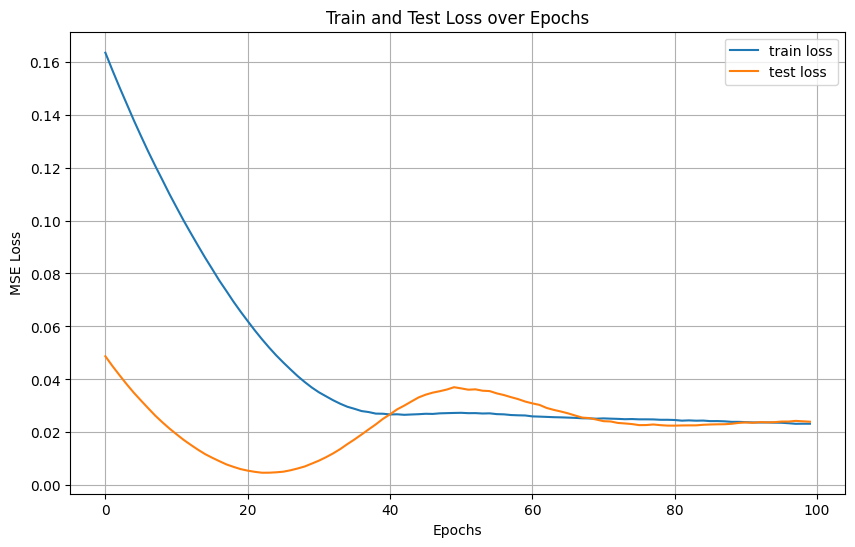

In [160]:
plt.figure(figsize=(10,6))
plt.plot(range(epoch_num), loss_list, label='train loss')
plt.plot(range(epoch_num), test_loss_list, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [144]:
import tft_torch

In [145]:
dir(tft_torch)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [146]:
from pytorch_forecasting import TemporalFusionTransformer

In [147]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.615599,0.454943,0.628980,0.467510,0.556576,0.613765,0.691018,0.636233
2,0.612708,0.459449,0.626458,0.464878,0.550279,0.620783,0.636233,0.636233
3,0.601143,0.436920,0.621438,0.459689,0.512596,0.586145,0.636233,0.581468
4,0.599698,0.450437,0.621438,0.462320,0.515693,0.599955,0.581468,0.519656
5,0.605480,0.450437,0.626458,0.467510,0.521991,0.599955,0.519656,0.504203


In [148]:
X_train_tensor.shape

torch.Size([13935, 1, 7])

In [149]:
import torch.nn as nn

In [150]:
class TemporalFusionTransformerSimple(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dropout=0.1):
        super(TemporalFusionTransformerSimple, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_size]
        x = self.input_proj(x)  # [batch_size, seq_len, d_model]
        x = x.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # [batch_size, d_model]
        output = self.fc_out(x)  # [batch_size, 1]
        return output

In [151]:
input_size = 7
d_model = 64
nhead = 4
num_layers = 2
lr = 1e-3
epochs = 100

In [152]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [153]:
X_train_tensors = X_train_tensor.float().to(device)
X_test_tensors = X_test_tensor.float().to(device)
y_train_tensors = y_train_tensor.float().to(device)
y_test_tensors = y_test_tensor.float().to(device)


In [154]:
model = TemporalFusionTransformerSimple(input_size, d_model, nhead, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


c:\Users\MaxDH\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [155]:
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass — training
    output_train = model(X_train_tensors)
    loss_train = criterion(output_train, y_train_tensors)
    loss_train.backward()
    optimizer.step()

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        output_test = model(X_test_tensors)
        loss_test = criterion(output_test, y_test_tensors)

    # Store losses
    train_losses.append(loss_train.item())
    test_losses.append(loss_test.item())

    # Print progress every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss_train.item():.6f}, Test Loss: {loss_test.item():.6f}')


Epoch 10/100, Train Loss: 0.219683, Test Loss: 0.441596
Epoch 20/100, Train Loss: 0.091994, Test Loss: 0.013286
Epoch 30/100, Train Loss: 0.047216, Test Loss: 0.084500
Epoch 40/100, Train Loss: 0.036188, Test Loss: 0.015301
Epoch 50/100, Train Loss: 0.033189, Test Loss: 0.034384
Epoch 60/100, Train Loss: 0.031172, Test Loss: 0.022147
Epoch 70/100, Train Loss: 0.026109, Test Loss: 0.027254
Epoch 80/100, Train Loss: 0.014659, Test Loss: 0.014332
Epoch 90/100, Train Loss: 0.009810, Test Loss: 0.002501
Epoch 100/100, Train Loss: 0.007407, Test Loss: 0.001298


In [156]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensors).cpu().numpy()
    y_actual = y_test_tensors.cpu().numpy()


In [157]:
from sklearn.metrics import mean_squared_error


In [158]:
mse = mean_squared_error(y_actual, y_pred)
print(f"Test MSE: {mse:.6f}")


Test MSE: 0.001298


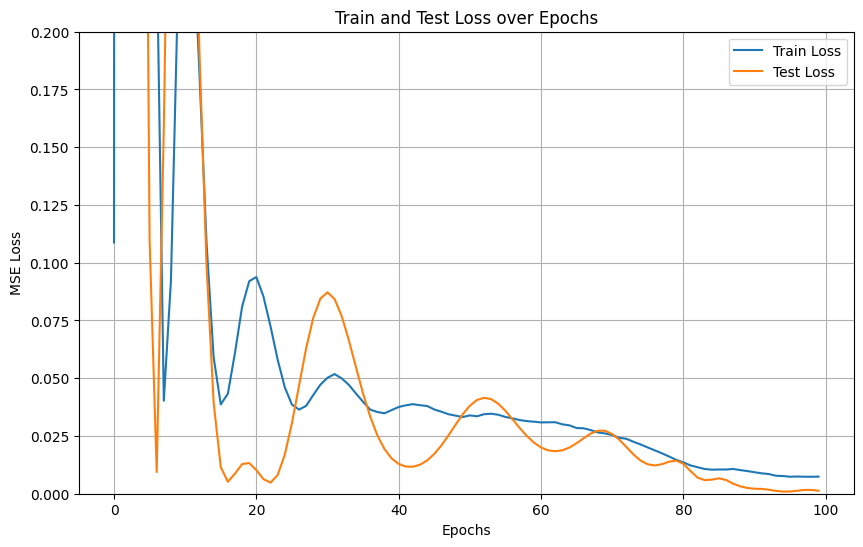

In [159]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_losses, label='Train Loss')  # Train loss on the y-axis
plt.plot(range(epochs), test_losses, label='Test Loss')    # Test loss on the y-axis
plt.ylim(0, 0.2)  # Adjust the upper limit based on your loss values

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Train and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
1,0.615599,0.454943,0.628980,0.467510,0.556576,0.613765,0.691018,0.636233
2,0.612708,0.459449,0.626458,0.464878,0.550279,0.620783,0.636233,0.636233
3,0.601143,0.436920,0.621438,0.459689,0.512596,0.586145,0.636233,0.581468
4,0.599698,0.450437,0.621438,0.462320,0.515693,0.599955,0.581468,0.519656
5,0.605480,0.450437,0.626458,0.467510,0.521991,0.599955,0.519656,0.504203


: 